# LSTM_RNN

### 6 months | 6 months

### target: EDSS_6...EDSS_222
- Time Steps: 37
- Evaluation: MSE 
- Imputation: Zero Imputation
- Features: Optimal 26

In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import sklearn as sk
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

/Users/matiasberretta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def select_columns(col_list, n_months):
    
    """takes in a list of column names and number of visits starting at 0
    returns column list time-stepped and dovetailed""" 
    
    return dovetail_names(*[time_step_names(i, n_months) for i in col_list])
        
def time_step_names(name, n_months):

    return [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6)]

def dovetail_names(*kwargs):
    zipped = zip(*kwargs)
    l = []
    for i in zipped:
        for j in i:
            l.append(j)
    return l

def stretch_input(Xtr, n_inputs, time_steps, pot):

    """Xtr_fill is empty 3D numpy array where we extend length of patient observation times t
    pot stands for Patient Observation Time. We only need to do this for our X input"""
    
    Xtr_fill = np.zeros(shape=[Xtr.shape[0],time_steps,n_inputs*pot] , dtype = object) 

    for subject in range(Xtr.shape[0]):
    
        for i in range(time_steps):

            temp = np.concatenate([Xtr[subject][i],Xtr[subject][i+1]]) # changed for pot = 3
            Xtr_fill[subject][i] = temp
            
    return Xtr_fill

def stack_times(data, name, n):
    
    
    """takes in dataframe, column name and n of time steps
    and puts it in long format"""
    
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        l.append(data[col].copy())
    
    stacked = l[0]
    rest = l[1:]
    
    # stack Series and get dummy variables 
    stacked.append(rest)
    
    return stacked

def stack_dummy(data, name, n):
    
    
    """takes in dataframe and column name
    return that same feature split into dummy columns
    across n time steps (adjacent)"""
    
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        l.append(data[col].copy())
    
    f = l[0]
    rest = l[1:]
    
    # stack Series and get dummy variables 
    pre_dummy = pd.get_dummies(f.append(rest))
    
    after_dummy = time_dummy(pre_dummy, n)
    
    dummy_value_names = generate_col_names(after_dummy, name)
    time_stepped_dummy_names = time_step_dummy_value_names(dummy_value_names, n)
    
    for t in range(len(after_dummy)):
        
        after_dummy[t].columns = list(time_stepped_dummy_names[t])
        
    #untimed_names_to_order = column_names_per_time_step(col_names_together, "what are you", name[0])
    #names_to_order = select_columns(untimed_names_to_order, n-1)

    return pd.concat(after_dummy, axis = 1, sort = False), dummy_value_names


def time_dummy(dummy_df, n):
    
    """Separates long data frame into time steps 
    (508 subjects (rows) per time step)"""
    
    l = []
    for i in range(n):
        l.append(dummy_df.iloc[i*508:(i+1)*508,:].copy())
    
    return l

def generate_col_names(after_dummy, name):
    
    """Generates column names for result of pd.get_dummies on a feature
    i.e. if A has values x and y, it will generate A_x, A_y"""
    
    return [(str(name[0]) + "_" + str(list(after_dummy[0].columns)[i])) for i in range(len(list(after_dummy[0].columns)))]

def time_step_dummy_value_names(names, n_months):
    
    long_list = [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6) for name in names]
    return np.array(long_list).reshape(-1, len(names))

def add_columns(add_to, name, names_per_t, n):
    
    n = n + 1
    to_add, bare_names = stack_dummy(df, name, n)
    to_remove = select_columns(name, n-1)
    
    """add new dummied features to dataframes (copy)
    and remove undummied version of features
    name is a list
    
    encompasses stack_dummy"""
    
    newdf = add_to.copy()
    column_names = list(to_add.columns)
    
    for i in range(len(column_names)):
        newdf[column_names[i]] = to_add.iloc[:,i]
    newdf.drop(to_remove,axis = 1, inplace = True)
    
    #print(bare_names, name[0])
    
    names_per_t_updated = column_names_per_time_step(names_per_t, bare_names, name[0])
    namesOrder= select_columns(names_per_t_updated, n-1)
    return newdf[namesOrder].copy(), names_per_t_updated

#    return names_per_t_updated
#     print(name[0])
    
    
    return newdf[namesOrder].copy(), names_per_t_updated


def column_names_per_time_step(original_list, add, remove):
    """makes sure EDSS stays at the end
    remove pre """
    
    new_list = original_list.copy()
    
    
    new_list.remove(remove)
    new_list.extend(add)
    
    # makes sure EDSS is always last
    
    new_list.remove('EDSS')
    new_list.append('EDSS')
    
    return new_list

def manual_dummy(df, names, name_list, n):
    
    dfUpdated =df.copy()
    names = [[name] for name in names] # turn to list foramt so that it works
    
    for name in names:
        
        dfUpdated, name_list = add_columns(dfUpdated, name , name_list, n)
   
    return dfUpdated # should I return name_list as well?


# IMPORT DATA & DEFINE N OF TIME STEPS

In [32]:
Xold = pd.read_csv("data/X_6_months|6_months_exhaustive.csv", index_col = 0)
y = pd.read_csv("data/y_6_months|6_months_exhaustive.csv", index_col = 0)

predictive_features = pd.read_csv("predictive_features_list.csv", index_col = 0, header = None)
predictive_features_list = predictive_features[1].values.tolist()

n_time_steps = len(y.columns)
pot = 1
print("The RNN window will slide", n_time_steps, "times")
print("The input length of the training data will be", pot, "time slices, separated by 6 month intervals")

n_inputs_pure = len(predictive_features_list)
print(n_inputs_pure, "optimal featues")
predictive_features_list_timed = select_columns(predictive_features_list, n_time_steps-1)

X = Xold[predictive_features_list_timed].copy()

# Split into train and test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# X train n_time_steps will be +1 to account for stretching
# which will turn 11 time slices of 1 to 10 time slices of 2
X_train_reshaped = X_train.values.reshape(-1, n_time_steps, n_inputs_pure) # extra time step for stretch
y_train_reshaped = y_train.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_train_reshaped.shape))
print("y reshaped is " + str(y_train_reshaped.shape))

X_test_reshaped = X_test.values.reshape(-1, n_time_steps, n_inputs_pure)
y_test_reshaped = y_test.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_test_reshaped.shape))
print("y reshaped is " + str(y_test_reshaped.shape))

y_train = y_train_reshaped.astype(float)
y_test = y_test_reshaped.astype(float)
X_train = X_train_reshaped.astype(float)
X_test = X_test_reshaped.astype(float)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Set values for the neuron

In [48]:
n_inputs = n_inputs_pure * pot

n_neurons = 15

learning_rate = 0.01

n_steps = n_time_steps

print(n_inputs, "inputs per time step (",n_steps,") comprising", pot, "time slices,", n_inputs_pure, "features each")

26 inputs per time step ( 37 ) comprising 1 time slices, 26 features each


# Define Graph

In [49]:
# same as reshaping X_train, X_test, y_train, y_test, etc... except that instead of -1, we use None
X_tf = tf.placeholder(tf.float32, [None, n_time_steps, n_inputs], name = "X") # [None, 8, 27]
y_tf = tf.placeholder(tf.float32, [None, n_time_steps, 1], name = "y") # changed from tf.float32 to tf.int32 

lstm_cell = tf.contrib.rnn.LSTMCell(num_units = n_neurons, use_peepholes = True)
output_seqs, (c_states, h_states) = tf.nn.dynamic_rnn(lstm_cell, X_tf, dtype = tf.float32)

predictions = tf.contrib.layers.fully_connected(output_seqs, 1, activation_fn=tf.nn.relu)

loss = tf.losses.mean_squared_error(labels = y_tf, predictions = predictions)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Run Graph

In [55]:
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

n_epochs = 30
batch_sz = 100
mse_train = []
mse_test = []
allpredictions = []
alloutputs = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iter in range(len(X_train) // batch_sz):

            X_batch, y_batch = X_train[iter*batch_sz: (iter+1)*batch_sz], y_train[iter*batch_sz: (iter+1)*batch_sz]
            X_batch = X_batch.reshape(-1, n_steps, n_inputs)
            y_batch = y_batch.reshape(-1,n_steps, 1) # added 1
            sess.run(training_op, feed_dict={X_tf: X_batch, y_tf: y_batch})
                
        
        mse_train.append(sess.run(loss, feed_dict={X_tf: X_batch, y_tf: y_batch}))
    
        X_test_batch = X_test.reshape(-1, n_steps, n_inputs)
        y_test_batch = y_test.reshape(-1,n_steps,1)   
        
        mse_test.append(sess.run(loss, feed_dict={X_tf : X_test_batch, y_tf : y_test_batch}))
        
        allpredictions.append(sess.run(predictions, feed_dict={X_tf: X_test_batch}))

Pass all mse test at once

Train MSE: 0.2914845 Test MSE: 0.34756768


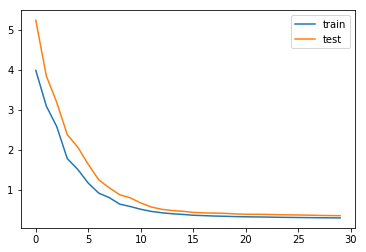

In [56]:
plt.plot(mse_train)
plt.plot(mse_test)
plt.legend(['train','test'])

print("Train MSE:", mse_train[-1], "Test MSE:", mse_test[-1])

In [67]:
print(np.min(mse_test))
print("epoch:",np.argmin(mse_test))

0.34756768
epoch: 29


In [68]:
print(y.shape, y_test.shape)

(508, 37) (153, 37, 1)


In [69]:
(y_test.shape == allpredictions[0].shape)

True

In [70]:
y.head()

,EDSS_6,EDSS_12,EDSS_18,EDSS_24,EDSS_30,EDSS_36,EDSS_42,EDSS_48,EDSS_54,EDSS_60,...,EDSS_168,EDSS_174,EDSS_180,EDSS_186,EDSS_192,EDSS_198,EDSS_204,EDSS_210,EDSS_216,EDSS_222
0,6.0,6.0,6.0,6.0,6.0,6.5,6.0,6.0,6.0,1.5,...,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
1,0.0,0.0,0.0,2.5,1.5,1.5,1.5,1.5,1.5,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,4.0,4.0,4.0,4.0,3.5,3.0,3.0,5.5,5.5,5.5,...,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.5
3,4.0,5.5,4.5,3.5,3.5,3.0,3.7,4.4,5.1,5.8,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
4,3.0,2.0,3.0,3.0,6.0,4.0,4.0,4.0,3.5,3.5,...,6.5,6.5,6.5,6.5,6.5,6.5,6.5,6.5,6.5,6.5
